In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

We calculate the satisfiability threshold for different values of $r$ (arXiv:2011.14270)

$$a_{sat} = \left( 2^{k-1} - \frac{1}{2} - \frac{1}{4\log 2}\right)\log 2 + o_k(1)$$


In [2]:
from math import log
def alpha_sat(k):
	return (2 ** (k - 1) - 0.5 - 1/(4 * log(2))) * log(2)

nae_sat_ratios = { k : round(alpha_sat(k), 2) for k in range(3,17)}
nae_sat_ratios

{3: 2.18,
 4: 4.95,
 5: 10.49,
 6: 21.58,
 7: 43.76,
 8: 88.13,
 9: 176.85,
 10: 354.29,
 11: 709.19,
 12: 1418.97,
 13: 2838.53,
 14: 5677.67,
 15: 11355.93,
 16: 22712.45}

Recall, $x$ satisfies a $k$-NAE-SAT instance iff $x$ satisfies the instance in the $k$-SAT formulation, and, for each clause, the literals within the clause are not all assigned the same truth value.

This means if $x$ satisfies a $k$-NAE-SAT instance then there is no clause where every literal has been set to true (and no clause where every literal has been set to false since the clause wouldn't be satisfied)...

I.e. $x$ satisfies a k-NAE-SAT instance iff $x$ and $\neg x$ satisfy the same instance in the k-SAT formulation.

As such, we create a new `nae_cnf.py` to encode this and use the same pytorch solver as before.


Analysing results:


In [4]:
ns = [n for n in range(12, 21)]
ks = [k for k in range(3, 11)]
ps = [1, 2, 4, 8, 16]
num_proc = 10
batch_size = 250

In [15]:
import json

# Load and combine JSON files
psuccs = {}
for k in ks:
	psuccs[k] = {}
	for n in ns:
		psuccs[k][n] = {p : 0 for p in ps}
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/p_succ_{n}_{k}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

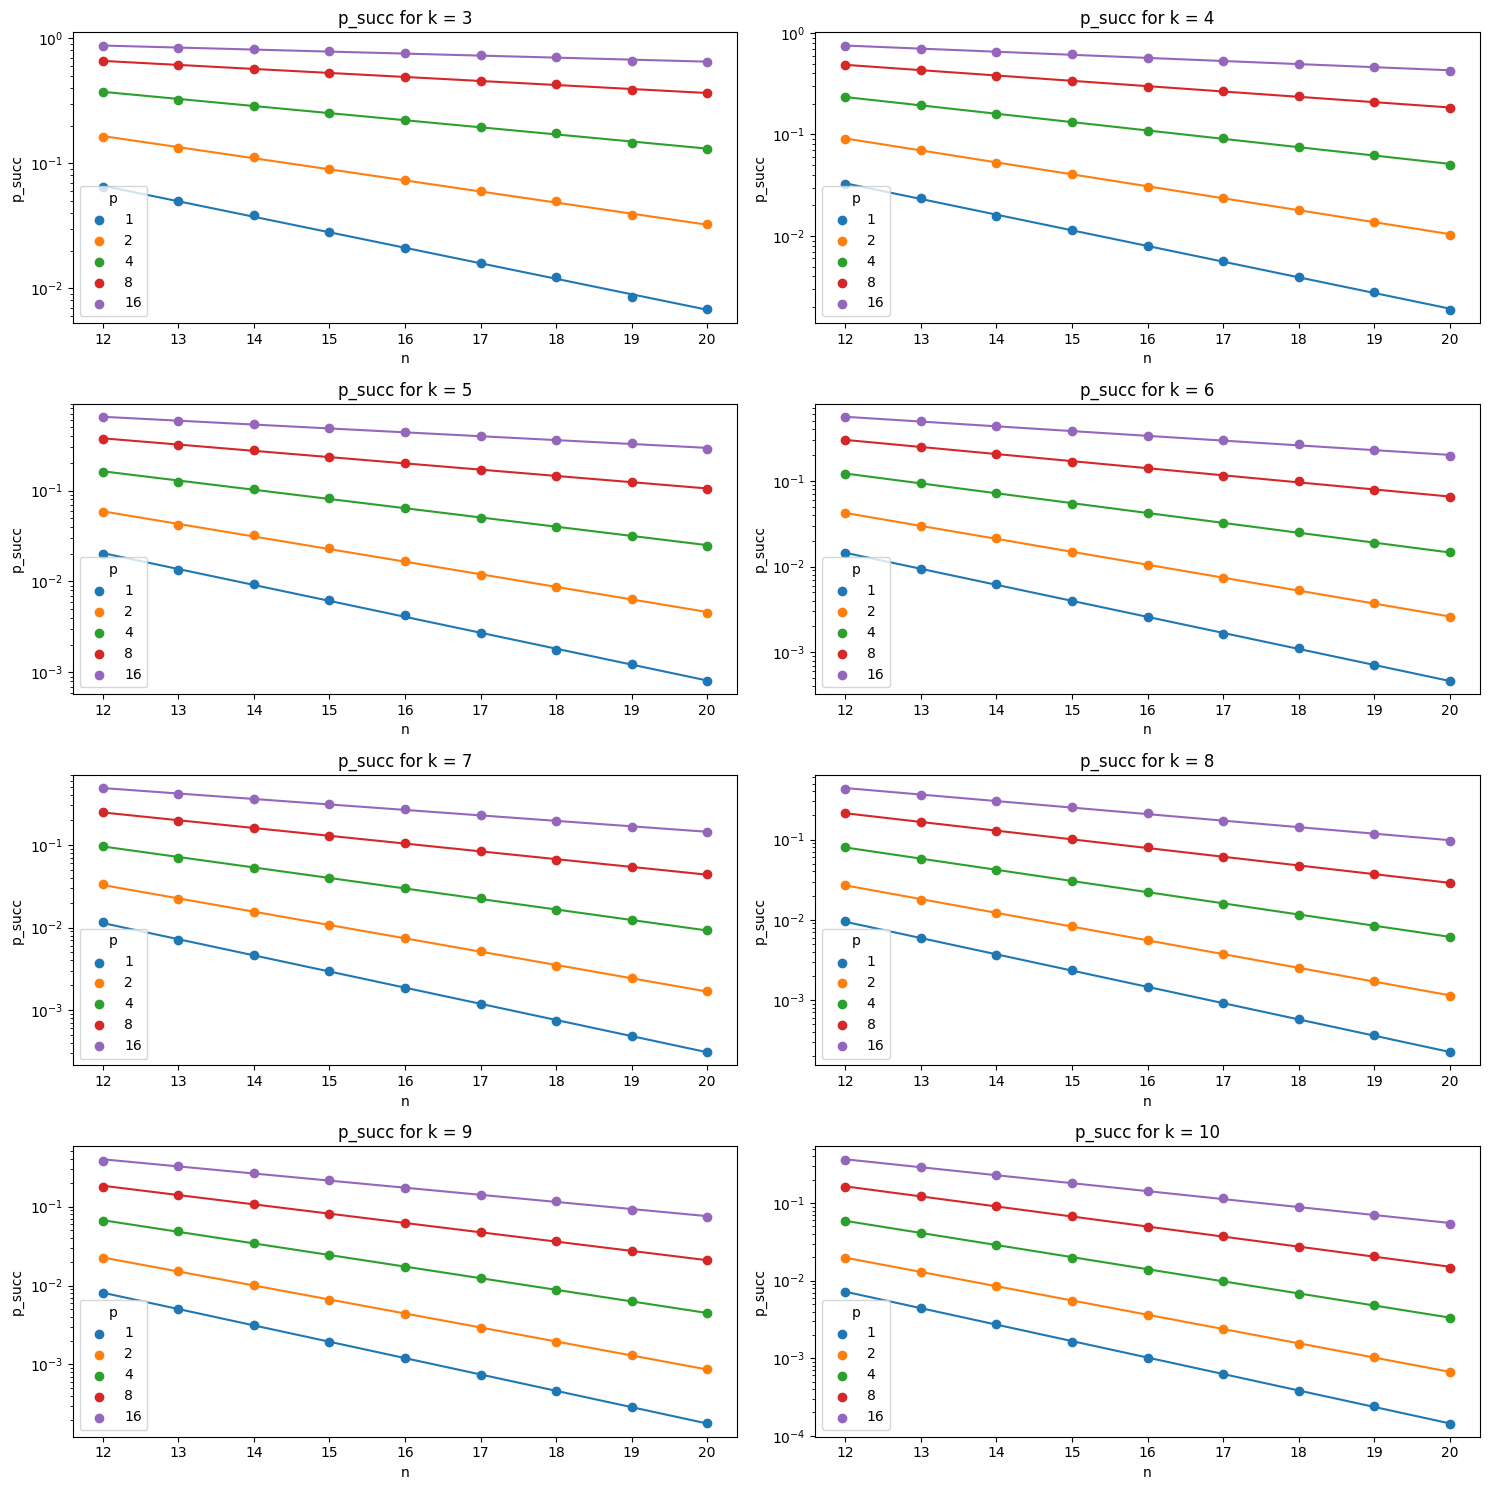

In [36]:
# Plot psuccs
import matplotlib.pyplot as plt
import numpy as np

# Store coeffs for comparison with mrt
psucc_coeffs = {}
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	psucc = psuccs[k]

	x = list(psucc.keys())
	ys = [[psucc[n][p] for n in x] for p in ps]

	psucc_coeffs[k] = {p : 0 for p in ps}

	for (p, y) in zip(ps, ys):
		# Points
		ax.scatter(x, y, label=p)

		# Line of best fit
		coefficients = np.polyfit(x, np.log(y), 1)
		psucc_coeffs[k][p] = coefficients.tolist()
		polynomial = np.poly1d(coefficients)
		#print(polynomial)
		ax.plot(x, np.exp(polynomial(x)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('p_succ')
	ax.legend(title='p')
	ax.set_title(f'p_succ for k = {k}')

fig.tight_layout()
plt.show()

First we find scaling predicted by psucc:

In [38]:
# Find coeffs by taking reciprocal
for k in ks:
	for p in ps:
		psucc_coeffs[k][p] = np.negative(psucc_coeffs[k][p])

In [39]:
import torch
import h5py
# Load, combine and calculate median running time from hdf5 files

parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp3/results"

mrts = {}
for k in ks:
	mrts[k] = {}
	for n in ns:
		mrts[k][n] = {}
		for p in ps:
			# Initialise empty tensor for runtimes
			rt = torch.zeros(size=(num_proc * batch_size, ))
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'{dir}/rt_{n}_{k}_{p}_{index}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					rt[index : index + batch_size] = fresh
			mrts[k][n][p] = torch.median(rt)

Plot scaling predicted by success probability vs median running time:

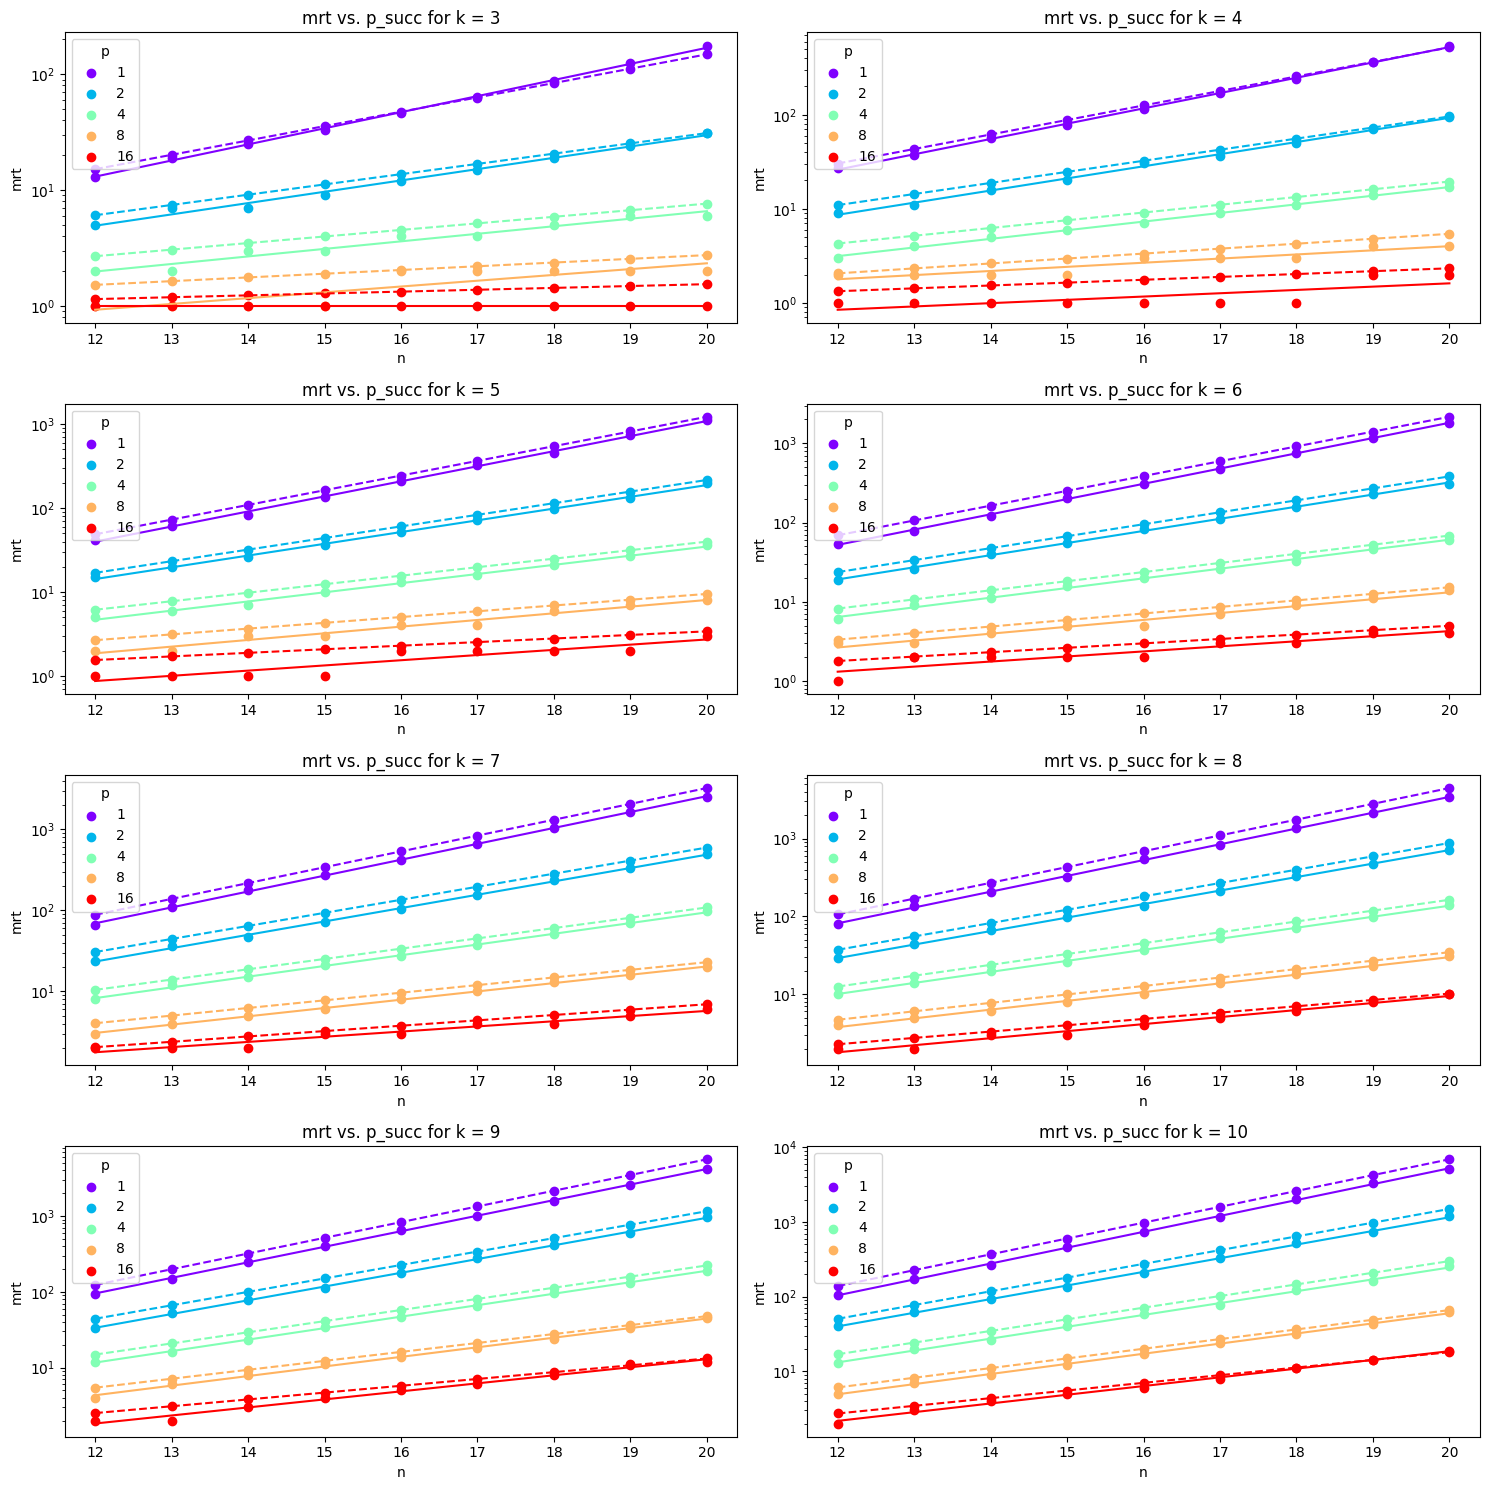

In [41]:
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	mrt = mrts[k]

	x = list(mrt.keys())
	ys = [[mrt[n][p] for n in x] for p in ps]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(ps))))

	for (p, y) in zip(ps, ys):
		c = next(color)
		# Points
		ax.scatter(x, y, label=p, color=c)

		# Line of best fit
		coefficients = np.polyfit(x, np.log(y), 1)
		polynomial = np.poly1d(coefficients)
		#print(polynomial)
		ax.plot(x, np.exp(polynomial(x)), color=c)

		# Psucc lines
		psucc_polynomial = np.poly1d(psucc_coeffs[k][p])
		#print(psucc_polynomial)
		ax.scatter(x, np.exp(psucc_polynomial(x)), color=c)
		ax.plot(x, np.exp(psucc_polynomial(x)), linestyle='dashed', color=c)

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('mrt')
	ax.legend(title='p')
	ax.set_title(f'mrt vs. p_succ for k = {k}')

fig.tight_layout()
plt.show()